In [1]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
import scipy.stats as st

# set plotting theme
from cycler import cycler
plt.style.use('default')
color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/"
dpi = 600

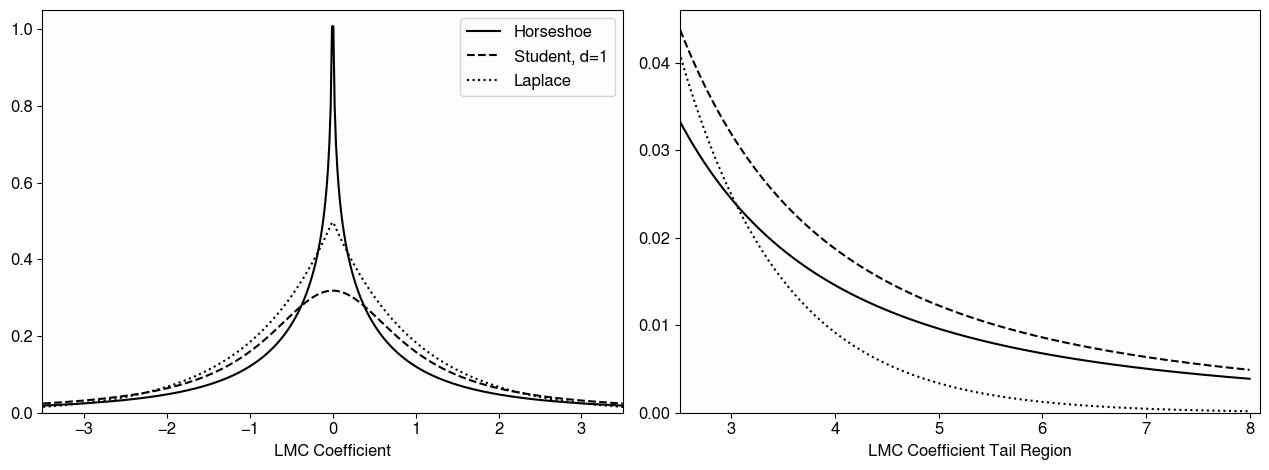

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4*2, 4.8))

theta = np.linspace(-8, 8, 1000)
hs = HorseshoePrior(1)
cauchy = dist.Cauchy(0,1) # equivalent to StudentT with one degree freedom
laplace = dist.Laplace(0,1) 
student = dist.StudentT(1,0,1.)

hs_pdf = hs.log_prob(theta).exp()
cauchy_pdf = cauchy.log_prob(torch.tensor(theta)).exp()
laplace_pdf = laplace.log_prob(torch.tensor(theta)).exp()
student_pdf = student.log_prob(torch.tensor(theta)).exp()

sns.lineplot(x=theta, y=hs_pdf, ls="solid", label="Horseshoe", c="black", ax=ax[0])
sns.lineplot(x=theta, y=student_pdf, ls="dashed", c="black", label="Student, d=1", ax=ax[0])
# sns.lineplot(x=theta, y=cauchy_pdf, ls="dashed", c="black", label="Cauchy", ax=ax[0])
sns.lineplot(x=theta, y=laplace_pdf, ls="dotted", c="black", label="Laplace", ax=ax[0])
ax[0].set_ylim([0, 1.05])
ax[0].set_xlim([-3.5,3.5]);
# plt.xlabel(r"$a_{d,j,q}$")
ax[0].set_xlabel(r"LMC Coefficient")

sns.lineplot(x=theta, y=hs_pdf, ls="solid", label="Horseshoe", c="black", ax=ax[1])
sns.lineplot(x=theta, y=student_pdf, ls="dashed", c="black", label="Student, d=1", ax=ax[1])
# sns.lineplot(x=theta, y=cauchy_pdf, ls="dashed", c="black", label="Cauchy", ax=ax[1])
sns.lineplot(x=theta, y=laplace_pdf, ls="dotted", c="black", label="Laplace", ax=ax[1])

ax[1].set_xlim([2.5, 8.1]);
ax[1].set_ylim([0,0.046])
ax[1].get_legend().remove()
ax[1].set_xlabel(r"LMC Coefficient Tail Region")

fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "lmc_prior_comparison.eps"), dpi=dpi, pad_inches=0)

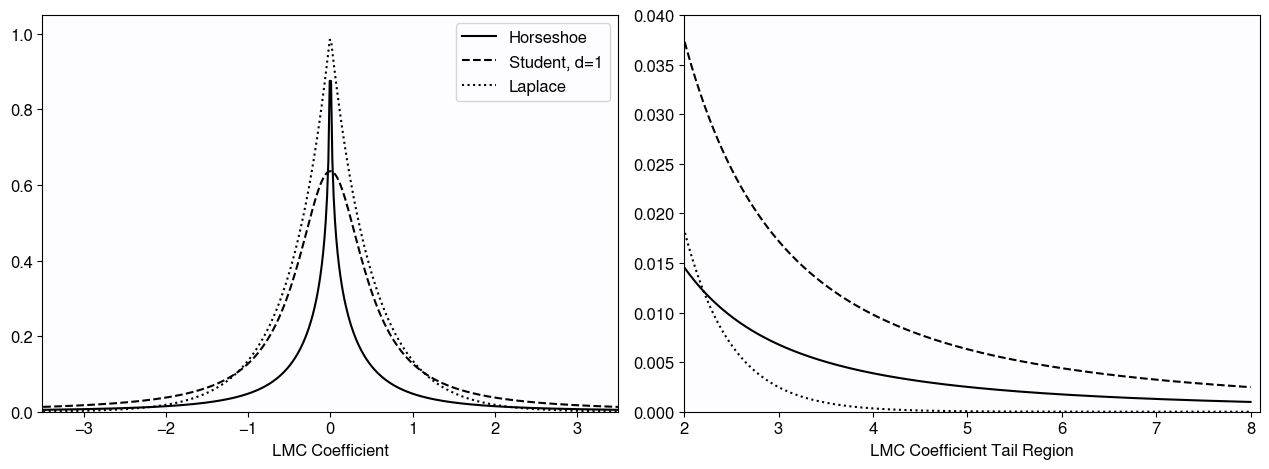

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4*2, 4.8))

theta = np.linspace(-8, 8, 1000)
hs = HorseshoePrior(.5)
cauchy = dist.Cauchy(0,.5) # equivalent to StudentT with one degree freedom
laplace = dist.Laplace(0,.5) 
student = dist.StudentT(1,0,.5)

hs_pdf = hs.log_prob(theta).exp()
cauchy_pdf = cauchy.log_prob(torch.tensor(theta)).exp()
laplace_pdf = laplace.log_prob(torch.tensor(theta)).exp()
student_pdf = student.log_prob(torch.tensor(theta)).exp()

sns.lineplot(x=theta, y=hs_pdf, ls="solid", label="Horseshoe", c="black", ax=ax[0])
sns.lineplot(x=theta, y=student_pdf, ls="dashed", c="black", label="Student, d=1", ax=ax[0])
# sns.lineplot(x=theta, y=cauchy_pdf, ls="dashed", c="black", label="Cauchy", ax=ax[0])
sns.lineplot(x=theta, y=laplace_pdf, ls="dotted", c="black", label="Laplace", ax=ax[0])
ax[0].set_ylim([0, 1.05])
ax[0].set_xlim([-3.5,3.5]);
# plt.xlabel(r"$a_{d,j,q}$")
ax[0].set_xlabel(r"LMC Coefficient")

sns.lineplot(x=theta, y=hs_pdf, ls="solid", label="Horseshoe", c="black", ax=ax[1])
sns.lineplot(x=theta, y=student_pdf, ls="dashed", c="black", label="Student, d=1", ax=ax[1])
# sns.lineplot(x=theta, y=cauchy_pdf, ls="dashed", c="black", label="Cauchy", ax=ax[1])
sns.lineplot(x=theta, y=laplace_pdf, ls="dotted", c="black", label="Laplace", ax=ax[1])

ax[1].set_xlim([2, 8.1]);
ax[1].set_ylim([0,0.04])
ax[1].get_legend().remove()
ax[1].set_xlabel(r"LMC Coefficient Tail Region")

fig.tight_layout()

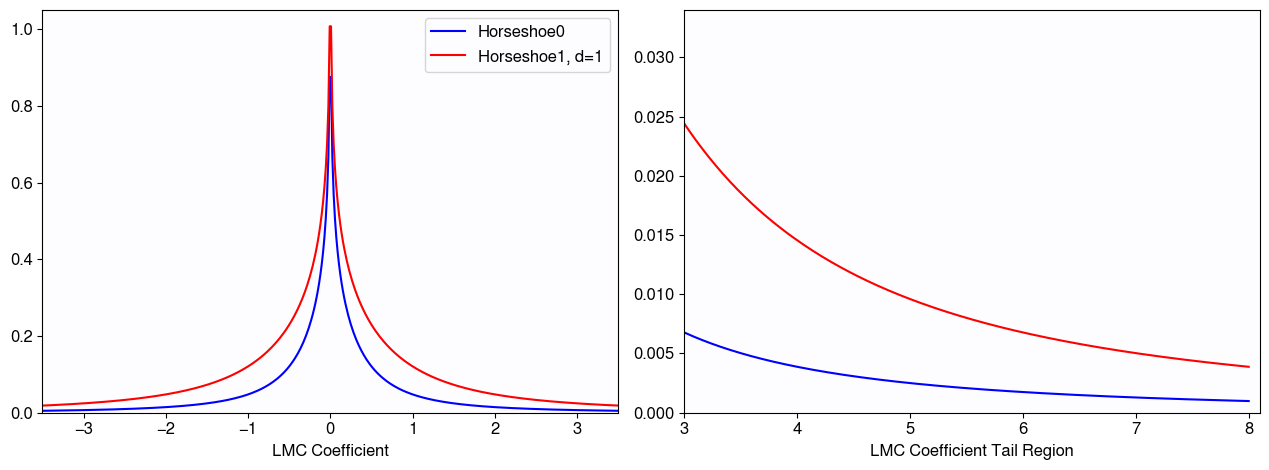

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.4*2, 4.8))

theta = np.linspace(-8, 8, 1000)
hs0 = HorseshoePrior(.5)
hs1 = HorseshoePrior(1.)

hs0_pdf = hs0.log_prob(theta).exp()
hs1_pdf = hs1.log_prob(theta).exp()

sns.lineplot(x=theta, y=hs0_pdf, ls="solid", label="Horseshoe0", c="blue", ax=ax[0])
sns.lineplot(x=theta, y=hs1_pdf, ls="solid", c="red", label="Horseshoe1, d=1", ax=ax[0])
ax[0].set_ylim([0, 1.05])
ax[0].set_xlim([-3.5,3.5]);
# plt.xlabel(r"$a_{d,j,q}$")
ax[0].set_xlabel(r"LMC Coefficient")

sns.lineplot(x=theta, y=hs0_pdf, ls="solid", label="Horseshoe0", c="blue", ax=ax[1])
sns.lineplot(x=theta, y=hs1_pdf, ls="solid", c="red", label="Horseshoe1, d=1", ax=ax[1])

ax[1].set_xlim([3, 8.1]);
ax[1].set_ylim([0,0.034])
ax[1].get_legend().remove()
ax[1].set_xlabel(r"LMC Coefficient Tail Region")

fig.tight_layout()

In [5]:
save_csv_path = "./model_comparisons_v1/kernels_len_3/"
lengthscales_df = pd.read_csv(os.path.join(save_csv_path, "lengthscales_df.csv"), index_col=0)
lmc_df =  pd.read_csv(os.path.join(save_csv_path, "lmc_df.csv"), index_col=0)
loo_df = pd.read_csv(os.path.join(save_csv_path, "loo_df.csv"), index_col=0)
loo_train_df = pd.read_csv(os.path.join(save_csv_path, "loo_train_df.csv"), index_col=0)
waic_df = pd.read_csv(os.path.join(save_csv_path, "waic_df.csv"), index_col=0)
waic_train_df = pd.read_csv(os.path.join(save_csv_path, "waic_train_df.csv"), index_col=0)
nlpd_df = pd.read_csv(os.path.join(save_csv_path, "nlpd_df.csv"), index_col=0)
agreement_df = pd.read_csv(os.path.join(save_csv_path, "agreement_df.csv"), index_col=0)
msce_df = pd.read_csv(os.path.join(save_csv_path, "msce_df.csv"), index_col=0)
kernel_structure_df = pd.read_csv(os.path.join(save_csv_path, "kernel_structure_df.csv"), index_col=0)
compute_times_df = pd.read_csv(os.path.join(save_csv_path, "compute_times_df.csv"), index_col=0)

In [9]:
# lengthscales_df = lengthscales_df.head(10)
# lmc_df = lmc_df.head(10)
# waic_df = waic_df.head(10)
# nlpd_df = nlpd_df.head(10)
# agreement_df = agreement_df.head(10)
# msce_df = msce_df.head(10)
# compute_times_df = compute_times_df.head(10)
# save_csv_path = "./model_comparisons/kernels_len_3/hs_vector_scale_0.1/"
# lengthscales_hs_df = pd.read_csv(os.path.join(save_csv_path, "lengthscales_df.csv"), index_col=0)
# lmc_hs_df =  pd.read_csv(os.path.join(save_csv_path, "lmc_df.csv"), index_col=0)
# waic_hs_df = pd.read_csv(os.path.join(save_csv_path, "waic_df.csv"), index_col=0)
# nlpd_hs_df = pd.read_csv(os.path.join(save_csv_path, "nlpd_df.csv"), index_col=0)
# agreement_hs_df = pd.read_csv(os.path.join(save_csv_path, "agreement_df.csv"), index_col=0)
# msce_hs_df = pd.read_csv(os.path.join(save_csv_path, "msce_df.csv"), index_col=0)
# compute_times_hs_df = pd.read_csv(os.path.join(save_csv_path, "compute_times_df.csv"), index_col=0)
# lengthscales_hs_df = lengthscales_hs_df.tail(10)
# lmc_hs_df =  lmc_hs_df.tail(10)
# waic_hs_df = waic_hs_df.tail(10)
# nlpd_hs_df = nlpd_hs_df.tail(10)
# agreement_hs_df = agreement_hs_df.tail(10)
# msce_hs_df = msce_hs_df.tail(10)
# compute_times_hs_df = compute_times_hs_df.tail(10)
# lengthscales_df["hs"] = 0
# lmc_df["hs"] = 0
# waic_df["hs"] = 0
# nlpd_df["hs"] = 0
# agreement_df["hs"] = 0
# msce_df["hs"] = 0
# compute_times_df["hs"] = 0

# lengthscales_hs_df["hs"] = 1
# lmc_hs_df["hs"] = 1
# waic_hs_df["hs"] = 1
# nlpd_hs_df["hs"] = 1
# agreement_hs_df["hs"] = 1
# msce_hs_df["hs"] = 1
# compute_times_hs_df["hs"] = 1

# lengthscales_df = pd.concat([lengthscales_df, lengthscales_hs_df])
# lmc_df = pd.concat([lmc_df, lmc_hs_df])
# waic_df = pd.concat([waic_df, waic_hs_df])
# nlpd_df = pd.concat([nlpd_df, nlpd_hs_df])
# agreement_df = pd.concat([agreement_df, agreement_hs_df])
# msce_df = pd.concat([msce_df, msce_hs_df])
# compute_times_df = pd.concat([compute_times_df, compute_times_hs_df])


# fig, ax = plt.subplots(figsize=(16,5), ncols=8)
# sns.boxplot(data=waic_df[(waic_df.test_id==0) & (waic_df.kcid==0)], x="hs", y="elpd_waic", linewidth=.5, fliersize=2, ax=ax[0], medianprops={"color": "white"})
# sns.boxplot(data=nlpd_df[(nlpd_df.test_id==0) & (nlpd_df.kcid==0)], x="hs", y="total_nlpd", linewidth=.5, fliersize=2, ax=ax[1], medianprops={"color": "white"})
# sns.boxplot(data=agreement_df[(agreement_df.test_id==0) & (agreement_df.kcid==0) & (agreement_df.weight=="quadratic")], x="hs", y="y0", linewidth=.5, fliersize=2, ax=ax[2], medianprops={"color": "white"})
# sns.boxplot(data=agreement_df[(agreement_df.test_id==0) & (agreement_df.kcid==0) & (agreement_df.weight=="quadratic")], x="hs", y="y3", linewidth=.5, fliersize=2, ax=ax[3], medianprops={"color": "white"})
# sns.boxplot(data=agreement_df[(agreement_df.test_id==0) & (agreement_df.kcid==0) & (agreement_df.weight=="quadratic")], x="hs", y="y4", linewidth=.5, fliersize=2, ax=ax[4], medianprops={"color": "white"})
# sns.boxplot(data=msce_df[(msce_df.test_id==0) & (msce_df.kcid==0)], x="hs", y="y1", linewidth=.5, fliersize=2, ax=ax[5], medianprops={"color": "white"})
# sns.boxplot(data=msce_df[(msce_df.test_id==0) & (msce_df.kcid==0)], x="hs", y="y2", linewidth=.5, fliersize=2, ax=ax[6], medianprops={"color": "white"})
# sns.boxplot(data=compute_times_df[(compute_times_df.test_id==0) & (compute_times_df.kcid==0)], x="hs", y="time_to_converge", linewidth=.5, fliersize=2, ax=ax[7], medianprops={"color": "white"})

# fig.tight_layout() 



In [38]:
.3*.05 + .3

0.315

In [37]:
.65*.05 + .65

0.6825

In [6]:
def geometric_mean(x):
    gm = np.exp(np.log(x).mean())
    return np.round(gm, 4)

data = [1, 2, 3, 40, 50, 60, 0.7, 0.88, 0.9, 1000]

print(geometric_mean(data))

waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']
waic_gm_df = waic_df.copy()
waic_gm_df[waic_cols] = waic_gm_df[waic_cols].apply(lambda x: x + np.abs(np.min(x)) + 1 if np.min(x) < 0 else x)
waic_gm_df["adj_elpd_waic"] = waic_gm_df[waic_cols].apply(lambda x: geometric_mean(x), axis=1)

nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4']
nlpd_gm_df = nlpd_df.copy()
nlpd_gm_df[nlpd_cols] = nlpd_gm_df[nlpd_cols].apply(lambda x: x + np.abs(np.min(x)) + 1 if np.min(x) < 0 else x)
nlpd_gm_df["adj_nlpd"] = nlpd_gm_df[nlpd_cols].apply(lambda x: geometric_mean(x), axis=1)

7.2463


In [7]:
agreement_cols = ["y0", "y3", "y4"]
agreement_gm_df = agreement_df.copy()
agreement_gm_df["arithmetic_mean"] = agreement_gm_df[agreement_cols].apply(lambda x: x.mean(), axis=1)
agreement_gm_df["geometric_mean"] = agreement_gm_df[agreement_cols].apply(lambda x: geometric_mean(x), axis=1)
agreement_gm_df["harmonic_mean"] = agreement_gm_df[agreement_cols].apply(lambda x: st.hmean(x) if (x > 0).all() else 0, axis=1)

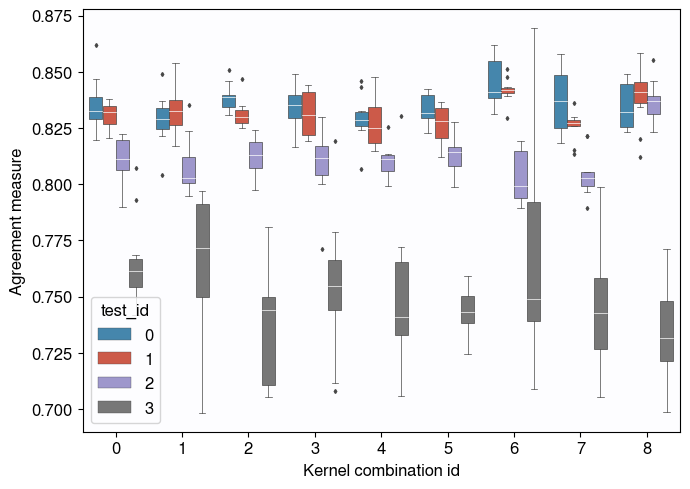

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
# model_legend = ["SA-HetMOGP", "A-HetMOGP", "Ind-GP", "HetMOGP"]
ax = sns.boxplot(data=agreement_gm_df[agreement_gm_df.weight=="quadratic"], x="kcid", y="y0", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("Agreement measure")
ax.set_xlabel("Kernel combination id")

fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

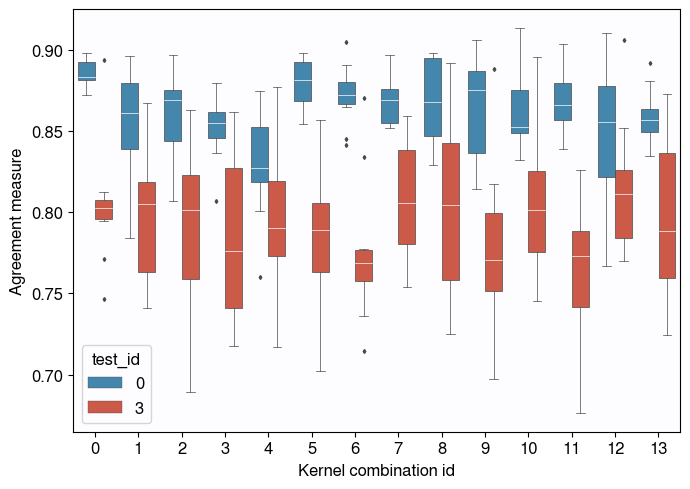

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
# model_legend = ["SA-HetMOGP", "A-HetMOGP", "Ind-GP", "HetMOGP"]
ax = sns.boxplot(data=agreement_gm_df[agreement_gm_df.weight=="quadratic"], x="kcid", y="arithmetic_mean", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("Agreement measure")
ax.set_xlabel("Kernel combination id")

fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

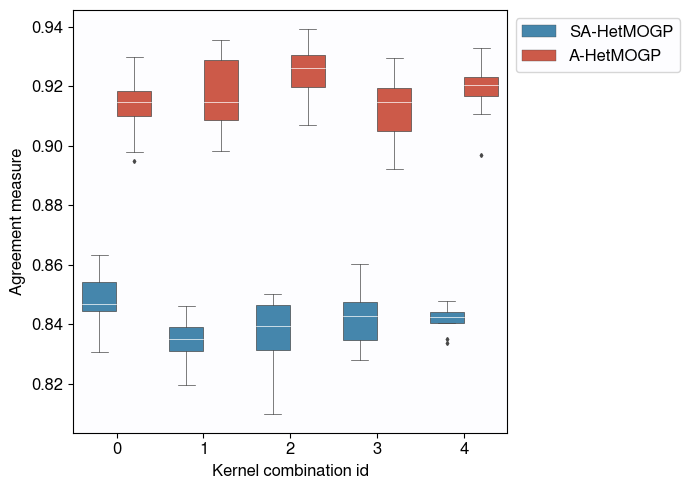

In [82]:
fig, ax = plt.subplots(figsize=(7,5))
model_legend = ["SA-HetMOGP", "A-HetMOGP", "Ind-GP", "HetMOGP"]
ax = sns.boxplot(data=agreement_df[agreement_df.weight=="quadratic"], x="kcid", y="y0", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("Agreement measure")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
# ax.get_legend().remove()

# ax[0,0].legend(handles, model_legend, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

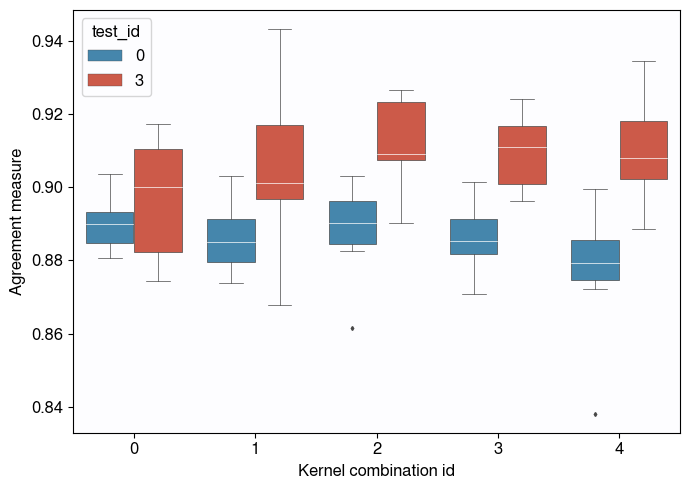

In [83]:
fig, ax = plt.subplots(figsize=(7,5))
# model_legend = ["SA-HetMOGP", "A-HetMOGP", "Ind-GP", "HetMOGP"]
ax = sns.boxplot(data=agreement_gm_df[agreement_gm_df.weight=="quadratic"], x="kcid", y="harmonic_mean", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("Agreement measure")
ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.get_legend().remove()

# ax[0,0].legend(handles, model_legend, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

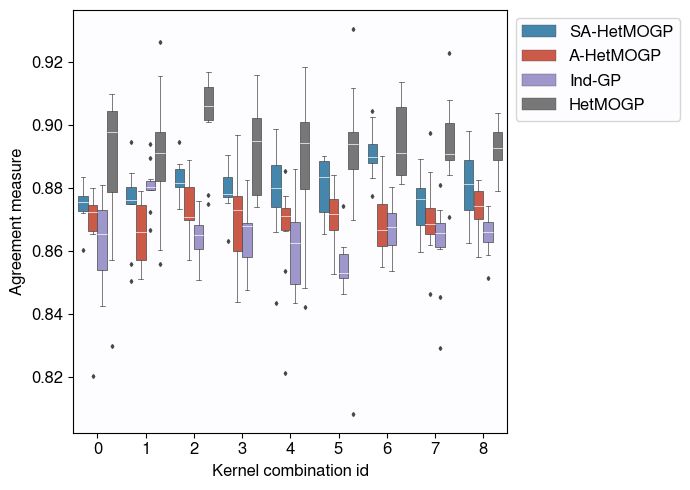

In [43]:
fig, ax = plt.subplots(figsize=(7,5))
model_legend = ["SA-HetMOGP", "A-HetMOGP", "Ind-GP", "HetMOGP"]
ax = sns.boxplot(data=agreement_gm_df[agreement_gm_df.weight=="quadratic"], x="kcid", y="harmonic_mean", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("Agreement measure")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
# ax.get_legend().remove()

# ax[0,0].legend(handles, model_legend, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

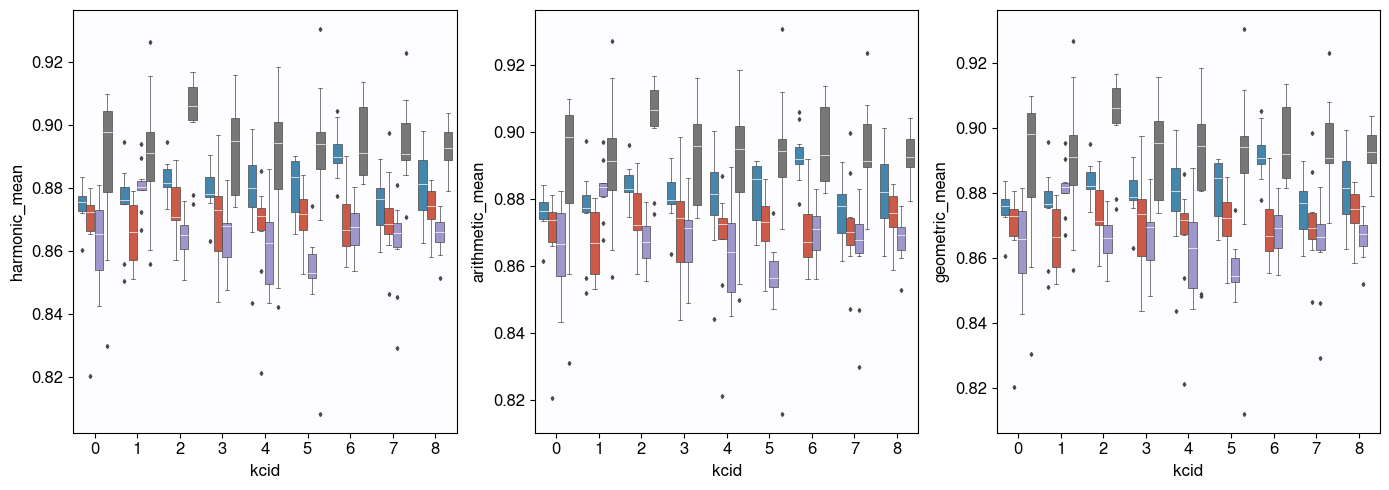

In [44]:
fig, ax = plt.subplots(figsize=(14,5), ncols=3)
model_legend = ["SA-HetMOGP", "A-HetMOGP", "Ind-GP", "HetMOGP"]
ax[0] = sns.boxplot(data=agreement_gm_df[(agreement_gm_df.weight=="quadratic")], x="kcid", y="harmonic_mean", hue="test_id", linewidth=.5, fliersize=2, medianprops={"color": "white"}, ax=ax[0])

sns.boxplot(data=agreement_gm_df[(agreement_gm_df.weight=="quadratic")], x="kcid", y="arithmetic_mean", hue="test_id", linewidth=.5, fliersize=2, medianprops={"color": "white"}, ax=ax[1])

sns.boxplot(data=agreement_gm_df[(agreement_gm_df.weight=="quadratic")], x="kcid", y="geometric_mean", hue="test_id", linewidth=.5, fliersize=2, medianprops={"color": "white"}, ax=ax[2])

# ax.set_ylabel("Agreement measure")
# ax[0].set_xlabel("Kernel combination id")
# handles, _ = ax[0].get_legend_handles_labels()
# ax.get_legend().remove()

# ax[0,0].legend(handles, model_legend, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
for i in range(3):
    ax[i].get_legend().remove() #bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

HD: calculate coefficient of variation

In [8]:
msce_cols = ["y1", "y2"]
msce_gm_df = msce_df.copy()
msce_gm_df["arithmetic_mean"] = msce_gm_df[msce_cols].apply(lambda x: x.mean(), axis=1)
msce_gm_df["geometric_mean"] = msce_gm_df[msce_cols].apply(lambda x: geometric_mean(x), axis=1)
msce_gm_df["harmonic_mean"] = msce_gm_df[msce_cols].apply(lambda x: st.hmean(x) if (x > 0).all() else 0, axis=1)

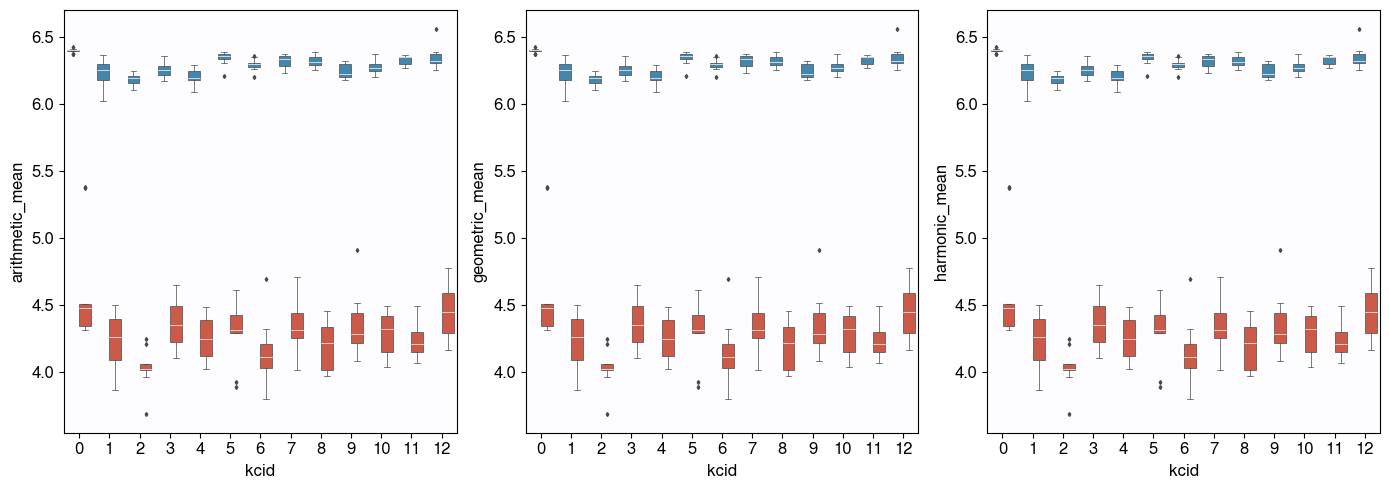

In [9]:
fig, ax = plt.subplots(figsize=(14,5), ncols=3)
msce_gm_df.kcid = msce_gm_df.kcid.astype(int)
sns.boxplot(data=msce_gm_df, x="kcid", y="arithmetic_mean", hue="test_id", linewidth=.5, fliersize=2,
            medianprops={"color": "white"}, ax=ax[0])
sns.boxplot(data=msce_gm_df, x="kcid", y="geometric_mean", hue="test_id", linewidth=.5, fliersize=2,
            medianprops={"color": "white"}, ax=ax[1])
sns.boxplot(data=msce_gm_df, x="kcid", y="harmonic_mean", hue="test_id", linewidth=.5, fliersize=2,
            medianprops={"color": "white"}, ax=ax[2])
# ax.set_ylabel("msce")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
for i in range(3):
    ax[i].get_legend().remove() 
fig.tight_layout()

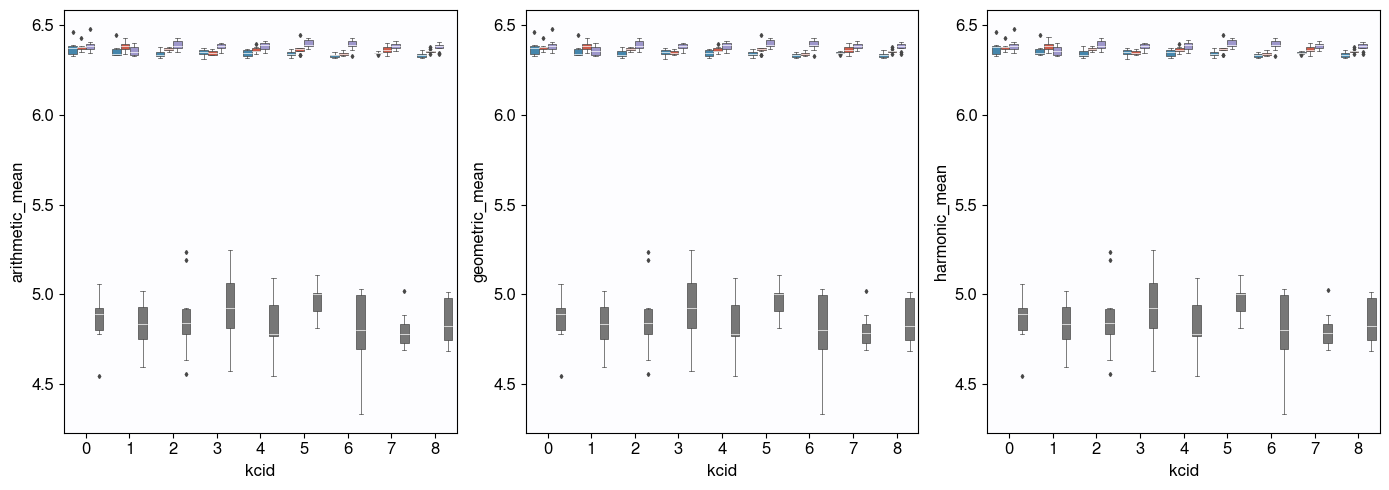

In [48]:
fig, ax = plt.subplots(figsize=(14,5), ncols=3)
msce_gm_df.kcid = msce_gm_df.kcid.astype(int)
sns.boxplot(data=msce_gm_df, x="kcid", y="arithmetic_mean", hue="test_id", linewidth=.5, fliersize=2,
            medianprops={"color": "white"}, ax=ax[0])
sns.boxplot(data=msce_gm_df, x="kcid", y="geometric_mean", hue="test_id", linewidth=.5, fliersize=2,
            medianprops={"color": "white"}, ax=ax[1])
sns.boxplot(data=msce_gm_df, x="kcid", y="harmonic_mean", hue="test_id", linewidth=.5, fliersize=2,
            medianprops={"color": "white"}, ax=ax[2])
# ax.set_ylabel("msce")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
for i in range(3):
    ax[i].get_legend().remove() 
fig.tight_layout()

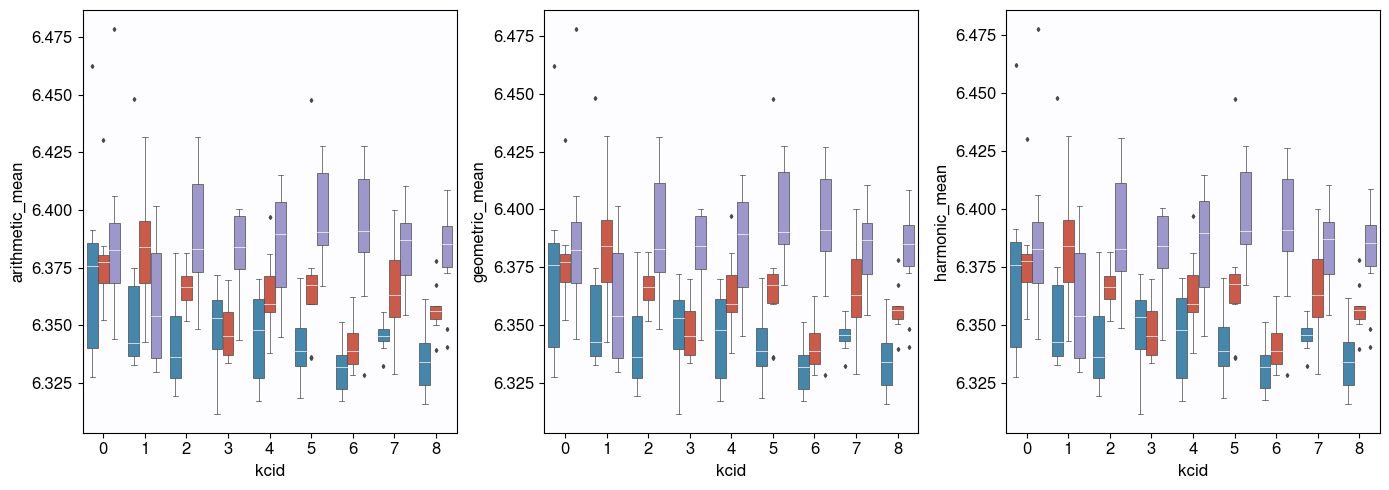

In [49]:
fig, ax = plt.subplots(figsize=(14,5), ncols=3)
msce_gm_df.kcid = msce_gm_df.kcid.astype(int)
sns.boxplot(data=msce_gm_df[msce_gm_df.test_id.isin([0,1,2])], x="kcid", y="arithmetic_mean", hue="test_id", linewidth=.5, fliersize=2, medianprops={"color": "white"}, ax=ax[0])
sns.boxplot(data=msce_gm_df[msce_gm_df.test_id.isin([0,1,2])], x="kcid", y="geometric_mean", hue="test_id", linewidth=.5, fliersize=2, medianprops={"color": "white"}, ax=ax[1])
sns.boxplot(data=msce_gm_df[msce_gm_df.test_id.isin([0,1,2])], x="kcid", y="harmonic_mean", hue="test_id", linewidth=.5, fliersize=2, medianprops={"color": "white"}, ax=ax[2])
# ax.set_ylabel("msce")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
for i in range(3):
    ax[i].get_legend().remove() 
fig.tight_layout()

NameError: name 'model_legend' is not defined

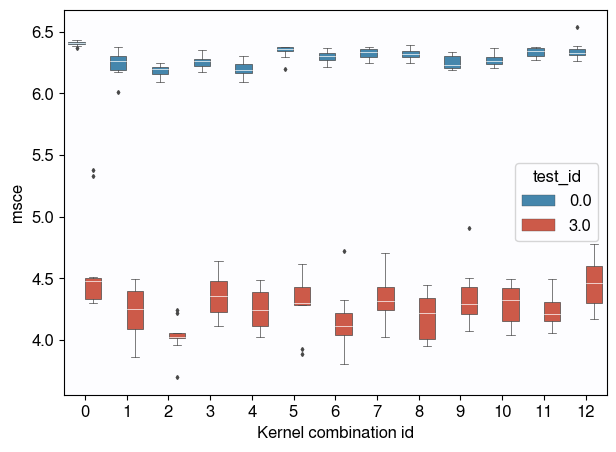

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
msce_df.kcid = msce_df.kcid.astype(int)
sns.boxplot(data=msce_df, x="kcid", y="y2", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("msce")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

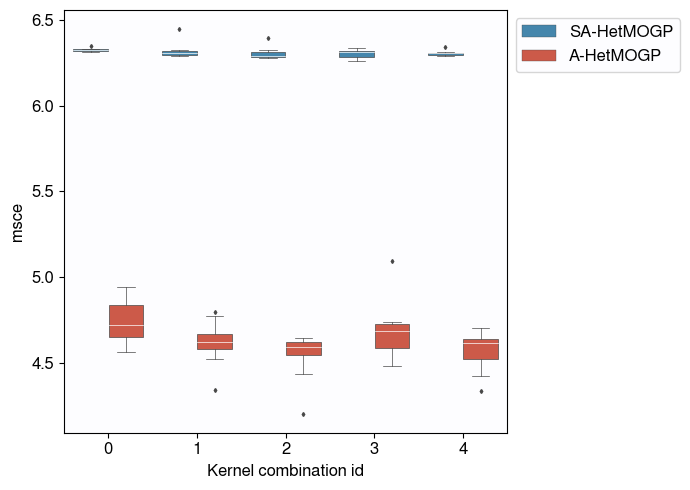

In [87]:
fig, ax = plt.subplots(figsize=(7,5))
msce_df.kcid = msce_df.kcid.astype(int)
sns.boxplot(data=msce_df, x="kcid", y="y1", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("msce")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

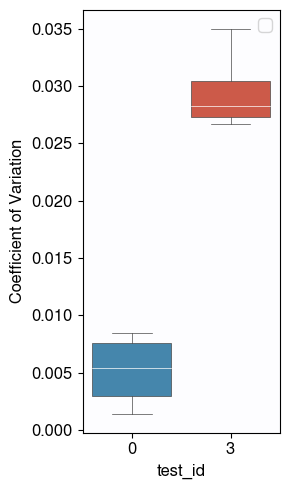

In [64]:
msce_meanstd_df = msce_gm_df.groupby(["kcid", "test_id"])[["harmonic_mean"]].agg(["mean", "std"]).droplevel(0, axis=1).reset_index()
msce_meanstd_df["cv"] = msce_meanstd_df["std"] / msce_meanstd_df["mean"]
fig, ax = plt.subplots(figsize=(3,5))
msce_meanstd_df.test_id = msce_meanstd_df.test_id.astype(int)
sns.boxplot(data=msce_meanstd_df, x="test_id", y="cv", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("Coefficient of Variation")
ax.set_xlabel("test_id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

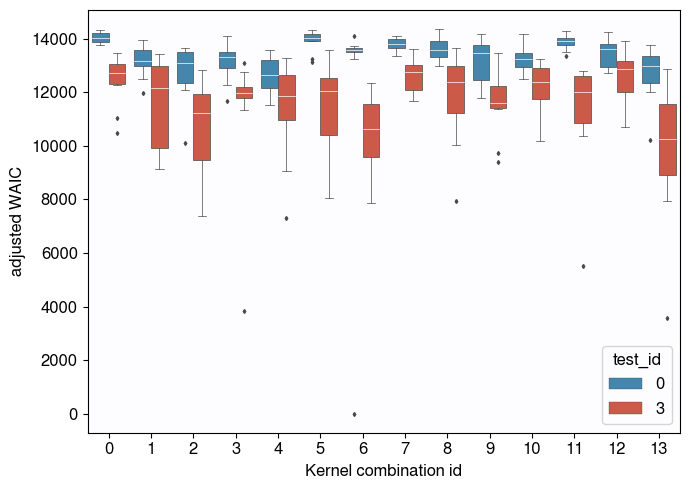

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=waic_gm_df, x="kcid", y="adj_elpd_waic", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("adjusted WAIC")
ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

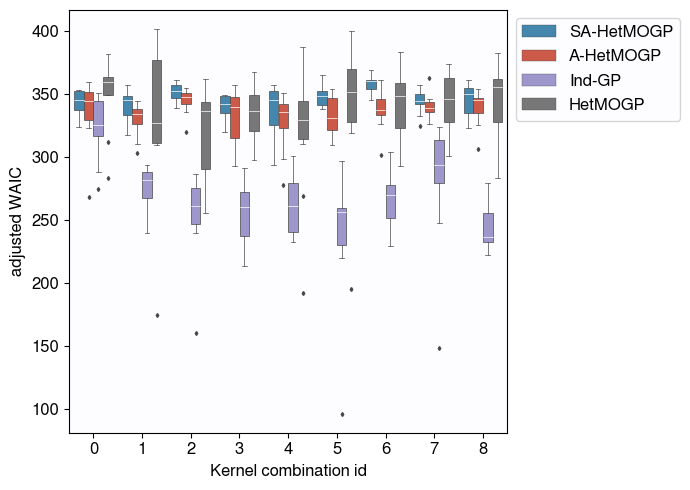

In [53]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=waic_gm_df, x="kcid", y="adj_elpd_waic", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("adjusted WAIC")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

In [50]:
waic_df[(waic_df.test_id.isin([2,3])) & (waic_df.kcid==0)].iloc[[0, -1]][waic_cols + ["elpd_waic"]]

,elpd_waic_y0,elpd_waic_y1,elpd_waic_y2,elpd_waic_y3,elpd_waic_y4,elpd_waic
0,-156.34626,4280.50378,4211.34315,-28.23251,-24.24421,8283.023965
0,-172.15955,4717.31175,4688.32097,-35.94378,-27.29699,9170.232386


In [55]:
waic_gm_df[(waic_gm_df.test_id.isin([2,3])) & (waic_gm_df.kcid==0)].iloc[[0, -1]][waic_cols + ["elpd_waic", "adj_elpd_waic"]]

,elpd_waic_y0,elpd_waic_y1,elpd_waic_y2,elpd_waic_y3,elpd_waic_y4,elpd_waic,adj_elpd_waic
20,222.51610,4559.66154,4575.42943,39.85276,28.68824,8802.291026,350.7338
39,320.72037,4308.03818,4377.46808,19.84991,15.23459,8417.454093,283.4286


In [77]:
waic_df.groupby(["test_id"])['elpd_waic'].agg(["mean", "std"])

,mean,std
test_id,,
0,8831.998141,16.062196
1,8820.899046,17.739475
2,8647.909110,61.213483
3,8322.487591,1066.927231


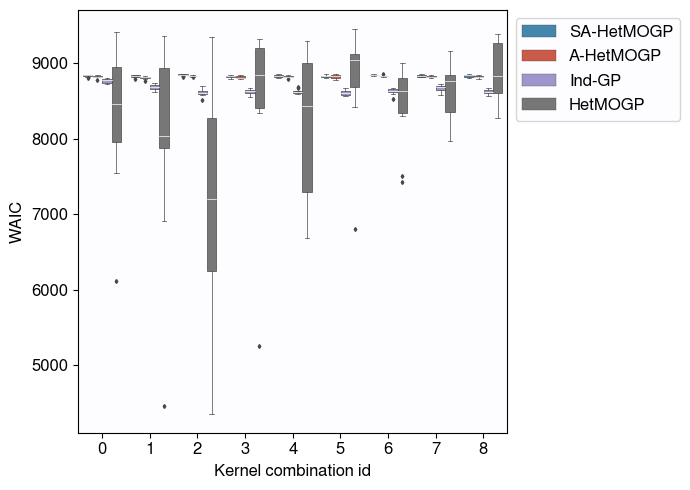

In [56]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=waic_df, x="kcid", y="elpd_waic", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("WAIC")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

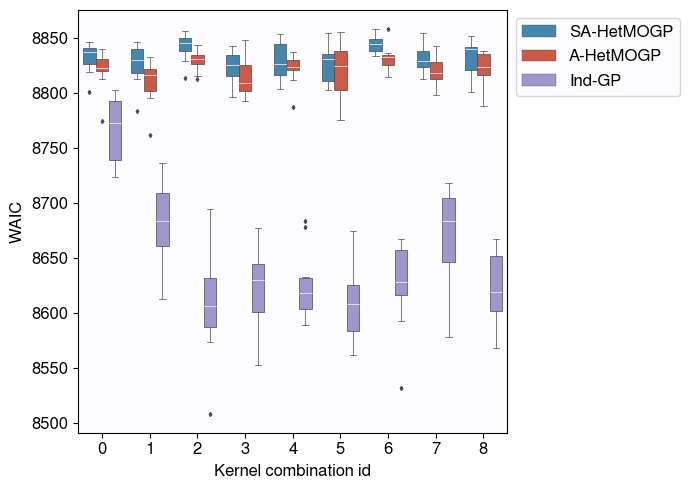

In [57]:
fig, ax = plt.subplots(figsize=(7,5))
nlpd_df.kcid = nlpd_df.kcid.astype(int)
sns.boxplot(data=waic_df[waic_df.test_id.isin([0,1, 2])], x="kcid", y="elpd_waic", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("WAIC")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

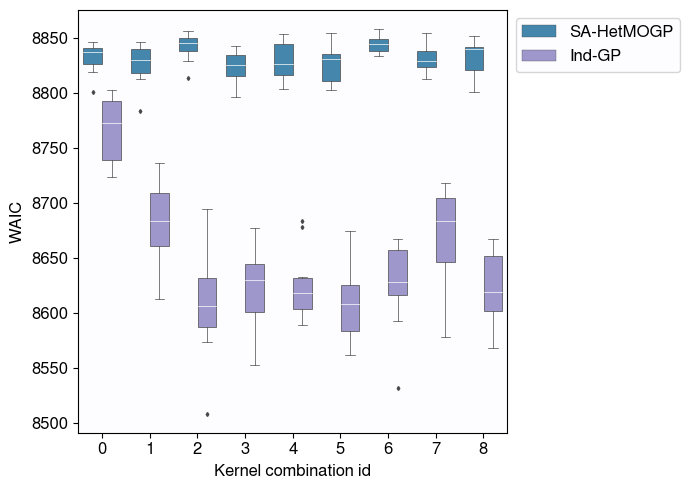

In [58]:
fig, ax = plt.subplots(figsize=(7,5))
nlpd_df.kcid = nlpd_df.kcid.astype(int)
sns.boxplot(data=waic_df[waic_df.test_id.isin([0,2])], x="kcid", y="elpd_waic", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"}, palette=[color_cycle[0], color_cycle[2]])
ax.set_ylabel("WAIC")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, [model_legend[0], model_legend[2]], bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

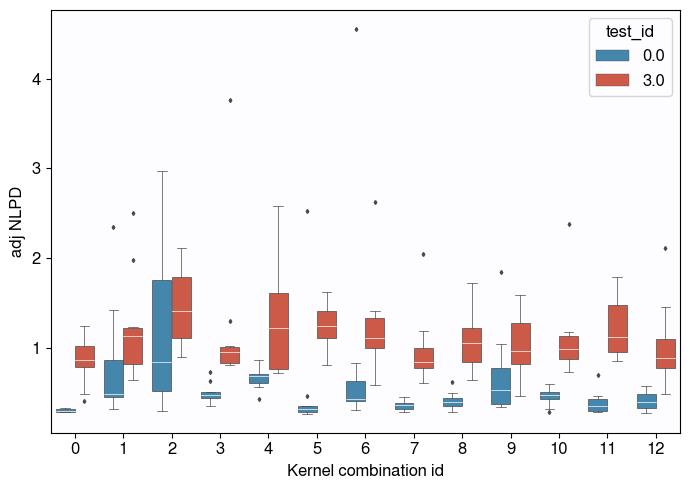

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
nlpd_gm_df.kcid = nlpd_gm_df.kcid.astype(int)
sns.boxplot(data=nlpd_gm_df, x="kcid", y="adj_nlpd", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("adj NLPD")
ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

In [71]:
.45/.323 - 1

0.3931888544891642

In [70]:
24.9/22.5 - 1

0.10666666666666669

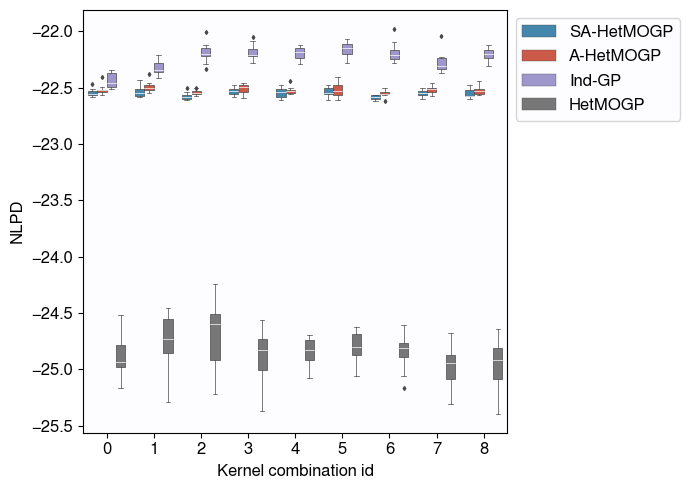

In [60]:
fig, ax = plt.subplots(figsize=(7,5))
nlpd_df.kcid = nlpd_df.kcid.astype(int)
sns.boxplot(data=nlpd_df, x="kcid", y="total_nlpd", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("NLPD")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

In [61]:
nlpd_gm_df

,test_id,kcid,lmc_prior_code,lengthscale_prior_code,y0,y1,y2,y3,y4,total_nlpd,adj_nlpd
0,0.0,0,2.0,1.0,0.680467,2.324349,2.324002,0.060901,0.077834,-22.563124,0.4449
1,0.0,0,2.0,1.0,0.673575,2.328723,2.327229,0.068387,0.067790,-22.564971,0.4423
2,0.0,0,2.0,1.0,0.662859,2.340335,2.329923,0.060756,0.083469,-22.553332,0.4494
3,0.0,0,2.0,1.0,0.662629,2.327134,2.320311,0.068256,0.068069,-22.584277,0.4407
4,0.0,0,2.0,1.0,0.647818,2.323315,2.331228,0.081615,0.077399,-22.569300,0.4668
...,...,...,...,...,...,...,...,...,...,...,...
355,3.0,8,2.0,1.0,0.436098,1.177891,1.170688,0.083922,0.061223,-25.100853,0.3148
356,3.0,8,2.0,1.0,0.415987,1.306647,1.304423,0.067313,0.076050,-24.860256,0.3251
357,3.0,8,2.0,1.0,0.463666,1.000000,1.000000,0.084471,0.091760,-25.390779,0.3244
358,3.0,8,2.0,1.0,0.449352,1.393482,1.393155,0.090572,0.062318,-24.641797,0.3455


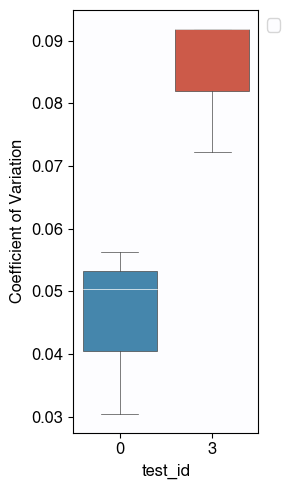

In [53]:
nlpd_meanstd_df = nlpd_gm_df.groupby(["kcid", "test_id"])[["adj_nlpd"]].agg(["mean", "std"]).droplevel(0, axis=1).reset_index()
nlpd_meanstd_df["cv"] = nlpd_meanstd_df["std"] / nlpd_meanstd_df["mean"]
fig, ax = plt.subplots(figsize=(3,5))
nlpd_meanstd_df.test_id = nlpd_meanstd_df.test_id.astype(int)
sns.boxplot(data=nlpd_meanstd_df, x="test_id", y="cv", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("Coefficient of Variation")
ax.set_xlabel("test_id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

In [63]:
nlpd_df[(nlpd_df.test_id.isin([2,3])) & (nlpd_df.kcid==0)].iloc[[0, -1]][nlpd_cols + ["total_nlpd"]]

,y0,y1,y2,y3,y4,total_nlpd
20,0.691041,-11.641277,-11.678559,0.058603,0.067550,-22.502641
39,0.455913,-12.704550,-12.702597,0.109335,0.101593,-24.740307


In [64]:
nlpd_gm_df[(nlpd_gm_df.test_id.isin([2,3])) & (nlpd_gm_df.kcid==0)].iloc[[0, -1]][nlpd_cols + ["total_nlpd", "adj_nlpd"]]

,y0,y1,y2,y3,y4,total_nlpd,adj_nlpd
20,0.691041,2.377991,2.332849,0.058603,0.067550,-22.502641,0.4327
39,0.455913,1.314718,1.308811,0.109335,0.101593,-24.740307,0.3873


HD: use weighted average. weight could be based on importance

In [65]:
waic_df.groupby(["test_id"]).median().reset_index()[["test_id", "p_waic"]]

,test_id,p_waic
0,0,14.280415
1,1,13.597598
2,2,132.462824
3,3,1327.777717


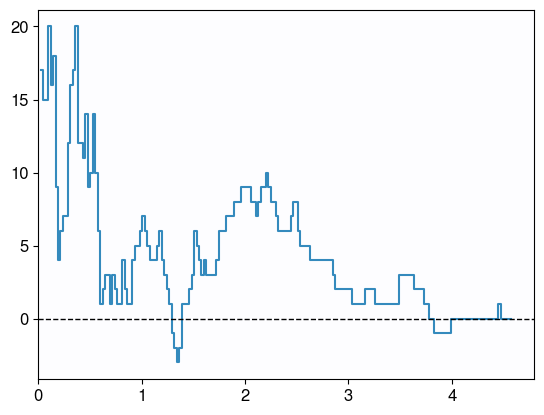

In [112]:
lmc0 = lmc_df[(lmc_df.test_id==0) & (lmc_df.kcid==0)].lmc_coeff.iloc[0]
lmc0 =  [float(i) for i in lmc0.strip('[|]').split()]
lmc1 = lmc_df[(lmc_df.test_id==1) & (lmc_df.kcid==0)].lmc_coeff.iloc[0]
lmc1 =  [float(i) for i in lmc1.strip('[|]').split()]

lmc_concat = np.concatenate([np.abs(lmc1), np.abs(lmc0)])
bins = np.linspace(0, lmc_concat.max()+.1, len(lmc0))
bins0 = np.linspace(0, lmc_concat.max()+.1, len(lmc0))
bins1 = np.linspace(0, lmc_concat.max()+.1, len(lmc0))
count0, count0_x = np.histogram(np.abs(lmc0), 
                           bins=bins)
count1, count1_x = np.histogram(np.abs(lmc1), 
                           bins=bins)

fig, ax = plt.subplots()

ax.step(x=bins[1:], y=(count0.cumsum() - count1.cumsum()), where="post", c=color_cycle[0])
ax.set_xlim(0)
_, xmax = ax.get_xlim()
ax.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

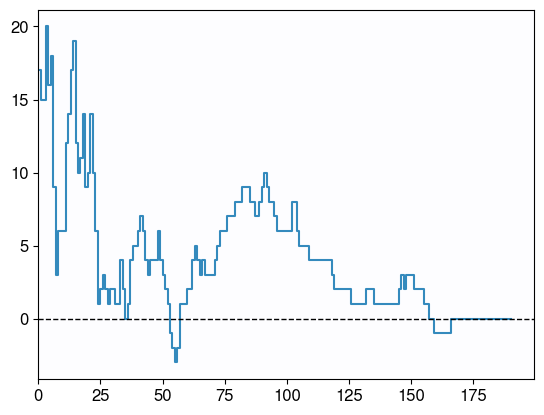

In [71]:
lmc0 = lmc_df[(lmc_df.test_id==0) & (lmc_df.kcid==0)].lmc_coeff.iloc[0]
lmc0 =  [float(i) for i in lmc0.strip('[|]').split()]
lmc1 = lmc_df[(lmc_df.test_id==1) & (lmc_df.kcid==0)].lmc_coeff.iloc[0]
lmc1 =  [float(i) for i in lmc1.strip('[|]').split()]

lmc_concat = np.concatenate([np.abs(lmc1), np.abs(lmc0)])
bins0 = np.linspace(0, np.abs(lmc0).max()+.1, len(lmc0))
bins1 = np.linspace(0, np.abs(lmc1).max()+.1, len(lmc0))
count0, count0_x = np.histogram(np.abs(lmc0), 
                           bins=bins0)
count1, count1_x = np.histogram(np.abs(lmc1), 
                           bins=bins1)

fig, ax = plt.subplots()

ax.step(x=np.arange(len(count0)), y=(count0.cumsum() - count1.cumsum()), where="post", c=color_cycle[0])
ax.set_xlim(0)
_, xmax = ax.get_xlim()
ax.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

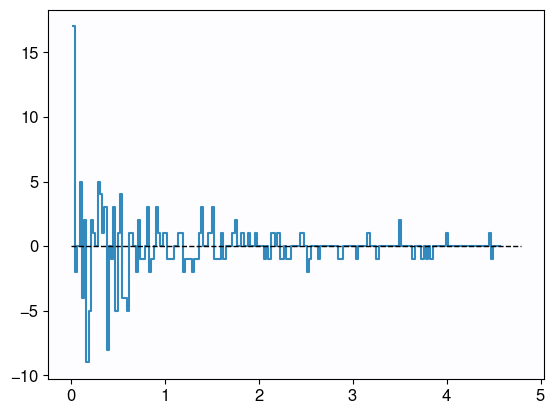

In [122]:
sns.lineplot(x=bins[1:], y=count0 - count1, drawstyle='steps-post')
plt.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

<AxesSubplot: >

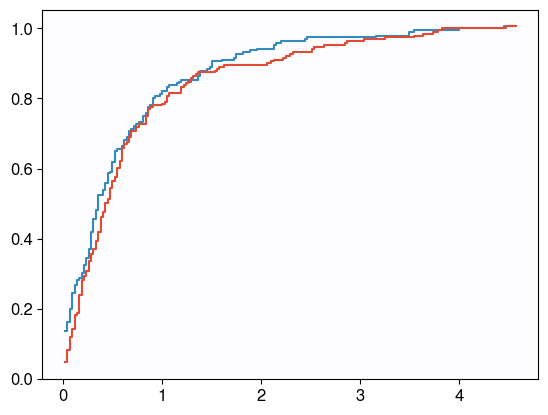

In [130]:
sns.lineplot(x=bins[1:], y=np.cumsum(count0)/len(count0), drawstyle='steps-post')
sns.lineplot(x=bins[1:], y=np.cumsum(count1)/len(count1), drawstyle='steps-post')

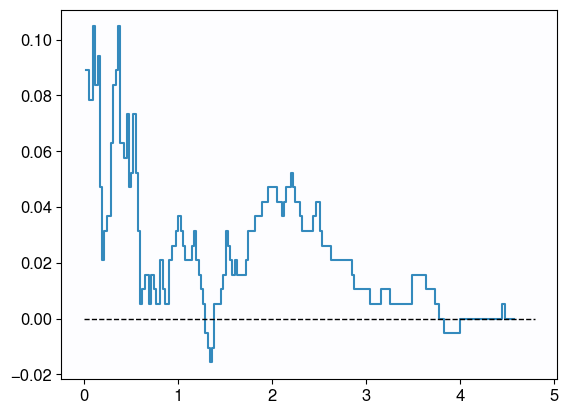

In [131]:
sns.lineplot(x=bins[1:], y=np.cumsum(count0)/len(count0) - np.cumsum(count1)/len(count1), drawstyle='steps-post')
# sns.lineplot(x=bins[1:], y=count1, drawstyle='steps-post')
# sns.lineplot(x=bins0[1:], y=count0.cumsum())
plt.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

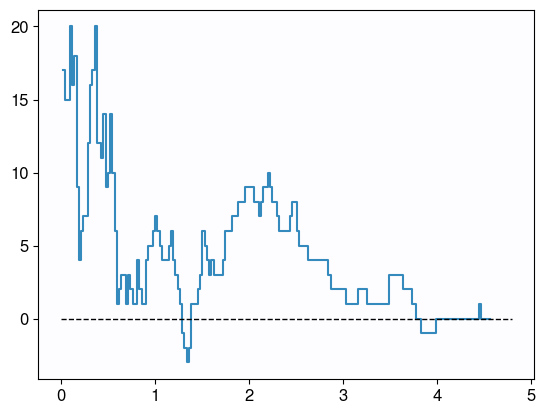

In [126]:
sns.lineplot(x=bins[1:], y=np.cumsum(count0) - np.cumsum(count1), drawstyle='steps-post')
# sns.lineplot(x=bins[1:], y=count1, drawstyle='steps-post')
# sns.lineplot(x=bins0[1:], y=count0.cumsum())
plt.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

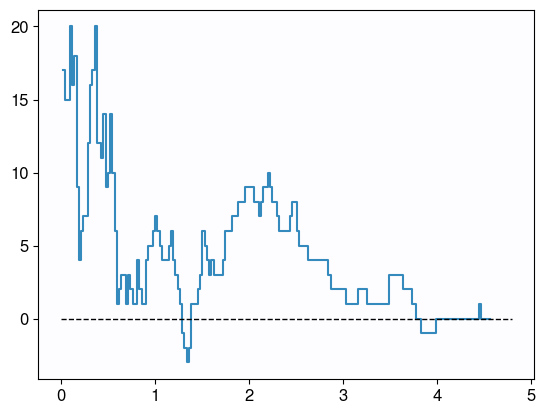

In [123]:
sns.lineplot(x=bins[1:], y=np.cumsum(count0 - count1), drawstyle='steps-post')
# sns.lineplot(x=bins[1:], y=count1, drawstyle='steps-post')
# sns.lineplot(x=bins0[1:], y=count0.cumsum())
plt.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

<AxesSubplot: >

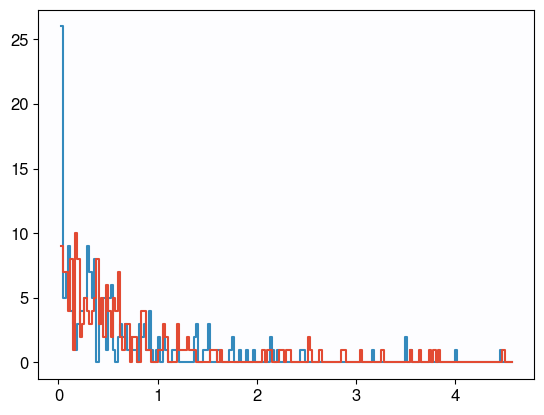

In [115]:
sns.lineplot(x=bins[1:], y=count0, drawstyle='steps-post')
sns.lineplot(x=bins[1:], y=count1, drawstyle='steps-post')
# sns.lineplot(x=bins0[1:], y=count0.cumsum())

<AxesSubplot: >

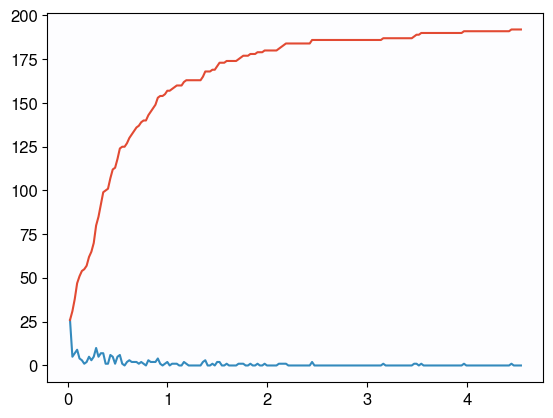

In [85]:
sns.lineplot(x=bins0[1:], y=count0)
# sns.lineplot(x=bins1[1:], y=count1)
sns.lineplot(x=bins0[1:], y=count0.cumsum())

<AxesSubplot: >

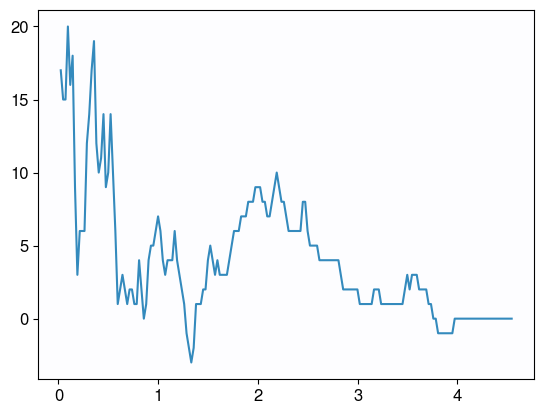

In [79]:
sns.lineplot(x=bins0[1:], y= np.cumsum(count0 - count1))
# sns.lineplot(x=bins1[1:], y=)

In [64]:
bins.shape, count0.shape

((192,), (191,))

<AxesSubplot: >

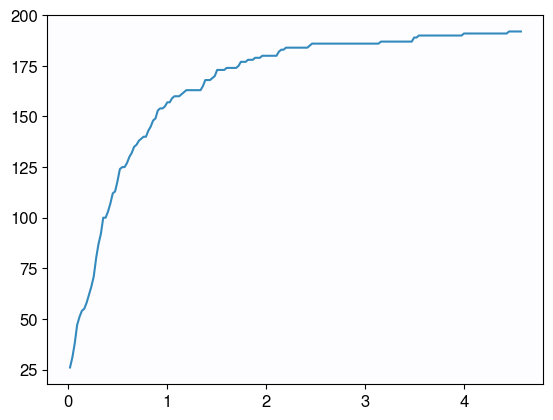

In [68]:
sns.lineplot(x=bins[1:], y=count0.cumsum())

In [54]:
count0

array([26,  5,  7,  9,  4,  3,  1,  3,  4,  4,  5,  9,  7,  5,  8,  0,  3,
        4,  5,  1,  5,  6,  1,  0,  2,  3,  2,  3,  1,  2,  1,  1,  0,  3,
        2,  3,  1,  4,  1,  0,  1,  2,  0,  2,  1,  0,  0,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  2,  3,  0,  0,  1,  1,  3,  0,  0,  0,  1,  0,
        0,  0,  0,  1,  2,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  2,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0])

<AxesSubplot: ylabel='Count'>

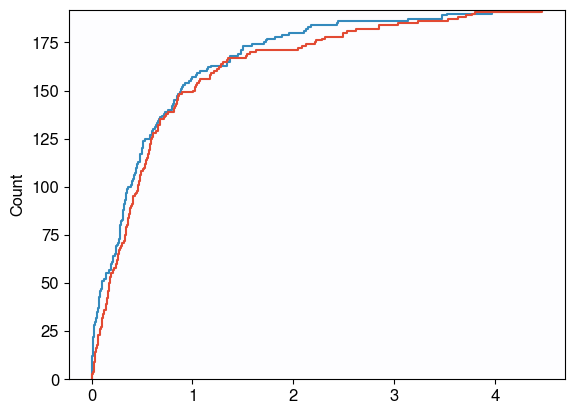

In [32]:
sns.ecdfplot(np.abs(lmc0), stat="count")
sns.ecdfplot(np.abs(lmc1), stat="count")

<AxesSubplot: >

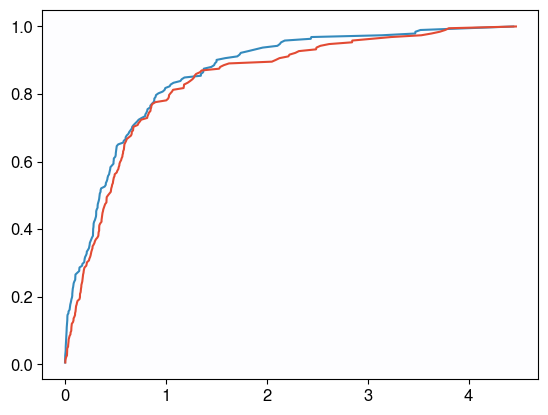

In [47]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf0 = ECDF(np.abs(lmc0))
ecdf1 = ECDF(np.abs(lmc1))
ecdf0_count = ecdf0.y * ecdf0.n
ecdf1_count = ecdf1.y * ecdf1.n
sns.lineplot(x=ecdf0.x, y=ecdf0.y)
sns.lineplot(x=ecdf1.x, y=ecdf1.y)

In [80]:
ecdf0.y - ecdf0.y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [50]:
 ecdf0.y - ecdf1.y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [41]:
ecdf1_count

array([  0.        ,   1.00520833,   2.01041667,   3.015625  ,
         4.02083333,   5.02604167,   6.03125   ,   7.03645833,
         8.04166667,   9.046875  ,  10.05208333,  11.05729167,
        12.0625    ,  13.06770833,  14.07291667,  15.078125  ,
        16.08333333,  17.08854167,  18.09375   ,  19.09895833,
        20.10416667,  21.109375  ,  22.11458333,  23.11979167,
        24.125     ,  25.13020833,  26.13541667,  27.140625  ,
        28.14583333,  29.15104167,  30.15625   ,  31.16145833,
        32.16666667,  33.171875  ,  34.17708333,  35.18229167,
        36.1875    ,  37.19270833,  38.19791667,  39.203125  ,
        40.20833333,  41.21354167,  42.21875   ,  43.22395833,
        44.22916667,  45.234375  ,  46.23958333,  47.24479167,
        48.25      ,  49.25520833,  50.26041667,  51.265625  ,
        52.27083333,  53.27604167,  54.28125   ,  55.28645833,
        56.29166667,  57.296875  ,  58.30208333,  59.30729167,
        60.3125    ,  61.31770833,  62.32291667,  63.32

In [39]:
ecdf0_count - ecdf1_count

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

(0.0, 5.0)

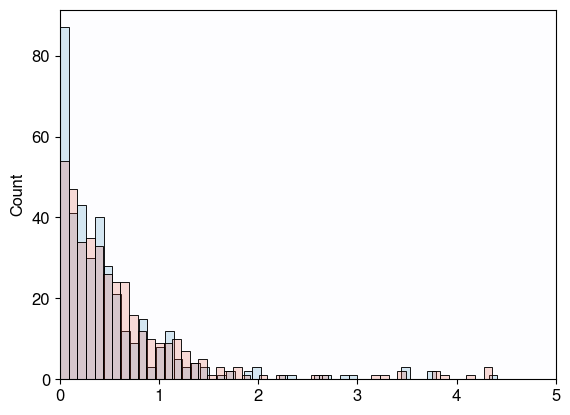

In [87]:
# fig, ax = plt.subplots(sharex=True)
sns.histplot(np.abs(lmc0), alpha=.2, bins=50)
sns.histplot(np.abs(lmc1), alpha=.2, bins=50)
plt.xlim(0,5)

array([0.00393062, 0.00404682, 0.00677998, 0.01157654, 0.01999895,
       0.02121508, 0.02145929, 0.02185819, 0.02256954, 0.0309314 ])

<AxesSubplot: ylabel='Density'>

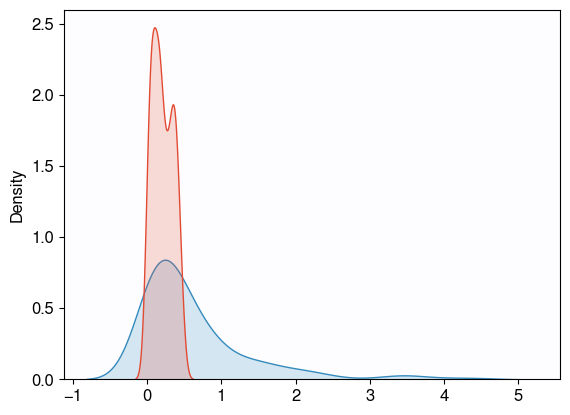

In [93]:
# fig, ax = plt.subplots(sharex=True)
sns.kdeplot(np.abs(lmc0), alpha=.2, fill=True)
sns.kdeplot(np.sort(np.abs(lmc1))[:100], alpha=.2, fill=True)
# plt.xlim(0)

<AxesSubplot: ylabel='Density'>

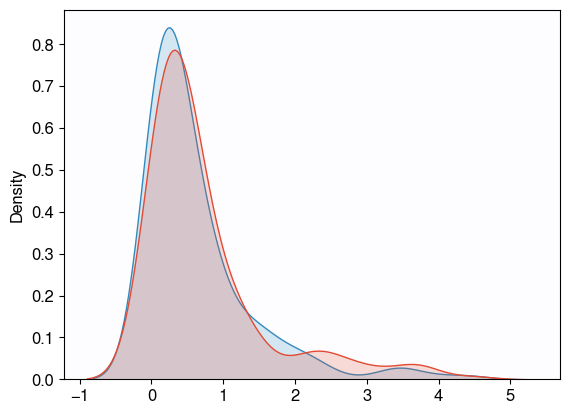

In [86]:
# fig, ax = plt.subplots(sharex=True)
sns.kdeplot(np.abs(lmc0), alpha=.2, fill=True)
sns.kdeplot(np.abs(lmc1), alpha=.2, fill=True)
# plt.xlim(0)

In [17]:
save_csv_path = "./model_comparisons/kernels_len_6/"
lengthscales6_df = pd.read_csv(os.path.join(save_csv_path, "lengthscales_df.csv"), index_col=0)
lmc6_df =  pd.read_csv(os.path.join(save_csv_path, "lmc_df.csv"), index_col=0)
loo6_df = pd.read_csv(os.path.join(save_csv_path, "loo_df.csv"), index_col=0)
loo6_train_df = pd.read_csv(os.path.join(save_csv_path, "loo_train_df.csv"), index_col=0)
waic6_df = pd.read_csv(os.path.join(save_csv_path, "waic_df.csv"), index_col=0)
waic6_train_df = pd.read_csv(os.path.join(save_csv_path, "waic_train_df.csv"), index_col=0)
nlpd6_df = pd.read_csv(os.path.join(save_csv_path, "nlpd_df.csv"), index_col=0)
agreement6_df = pd.read_csv(os.path.join(save_csv_path, "agreement_df.csv"), index_col=0)
msce6_df = pd.read_csv(os.path.join(save_csv_path, "msce_df.csv"), index_col=0)
kernel6_structure_df = pd.read_csv(os.path.join(save_csv_path, "kernel_structure_df.csv"), index_col=0)
compute6_times_df = pd.read_csv(os.path.join(save_csv_path, "compute_times_df.csv"), index_col=0)

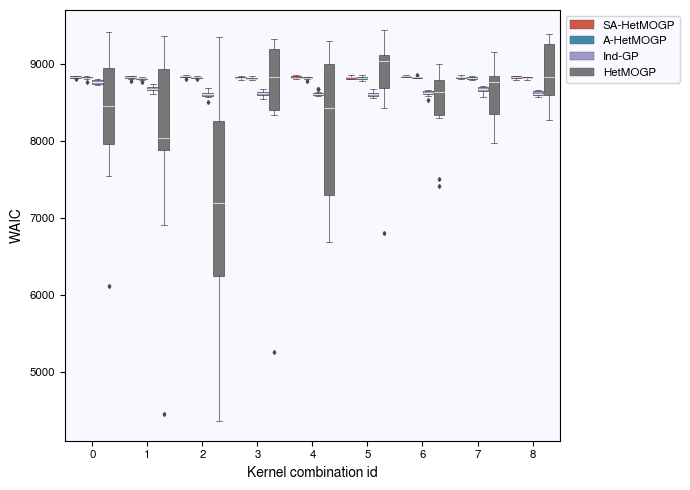

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=waic6_df, x="kcid", y="elpd_waic", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("WAIC")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

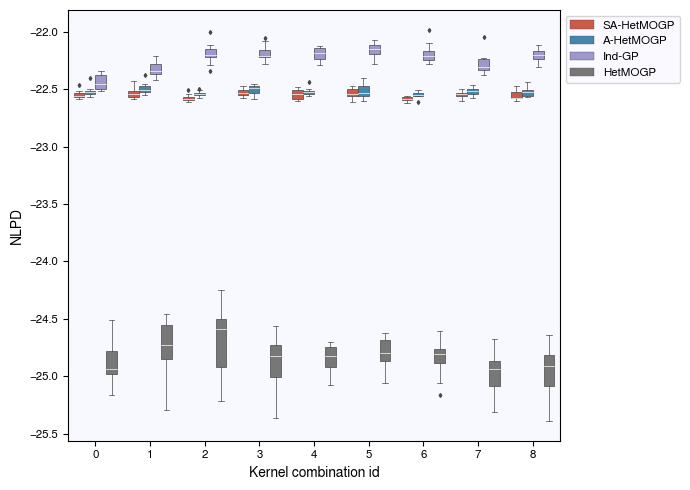

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
nlpd6_df.kcid = nlpd6_df.kcid.astype(int)
sns.boxplot(data=nlpd6_df, x="kcid", y="total_nlpd", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("NLPD")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

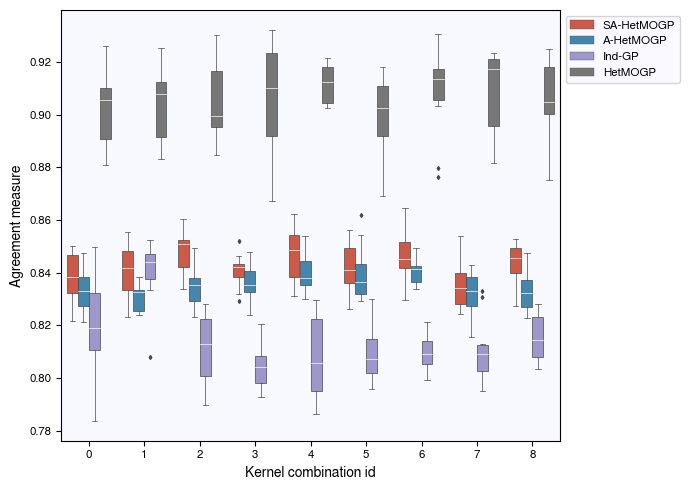

In [20]:
fig, ax = plt.subplots(figsize=(7,5))
ax = sns.boxplot(data=agreement6_df[agreement6_df.weight=="quadratic"], x="kcid", y="y0", hue="test_id", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("Agreement measure")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
# ax.get_legend().remove()

# ax[0,0].legend(handles, model_legend, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout() 
# plt.title("Model comparisons of additive and non-additive HetMOGP")
# fig.subplots_adjust(hspace=0)

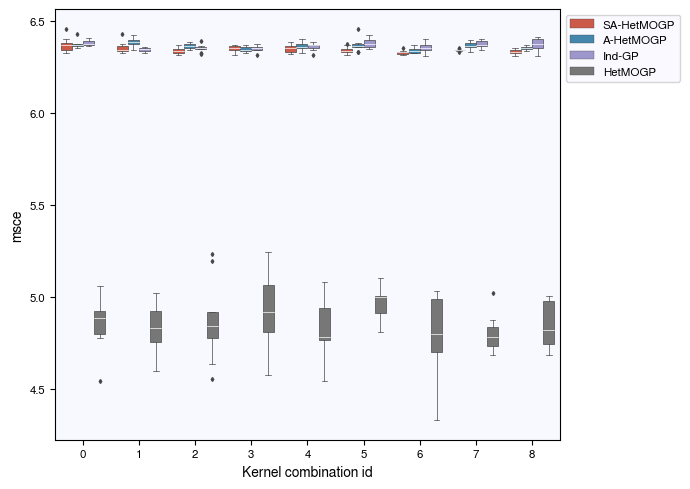

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
msce6_df.kcid = msce6_df.kcid.astype(int)
sns.boxplot(data=msce6_df, x="kcid", y="y2", hue="test_id", linewidth=.5, fliersize=2, ax=ax,
            medianprops={"color": "white"})
ax.set_ylabel("msce")
ax.set_xlabel("Kernel combination id")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

In [22]:
nlpd_df["n_kernels"] = 3
agreement_df["n_kernels"] = 3
msce_df["n_kernels"] = 3
waic_df["n_kernels"] = 3

nlpd6_df["n_kernels"] = 6
agreement6_df["n_kernels"] = 6
msce6_df["n_kernels"] = 6
waic6_df["n_kernels"] = 6

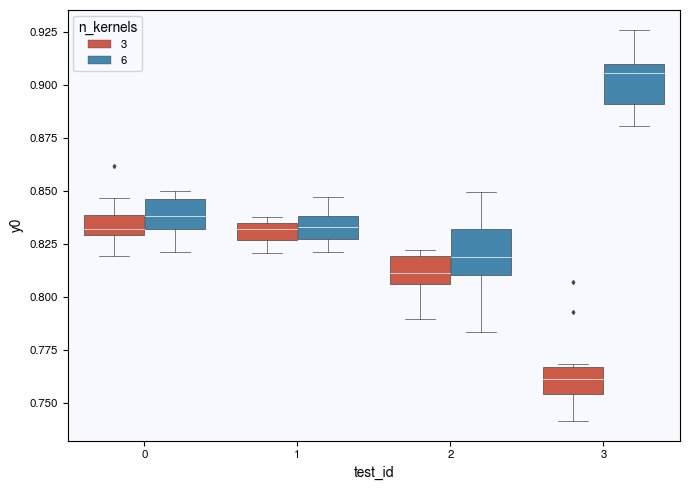

In [23]:
agreement_full = pd.concat([agreement_df, agreement6_df])
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=agreement_full[(agreement_full.kcid==0) & (agreement_full.weight=="quadratic")], x="test_id", y="y0", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Test id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

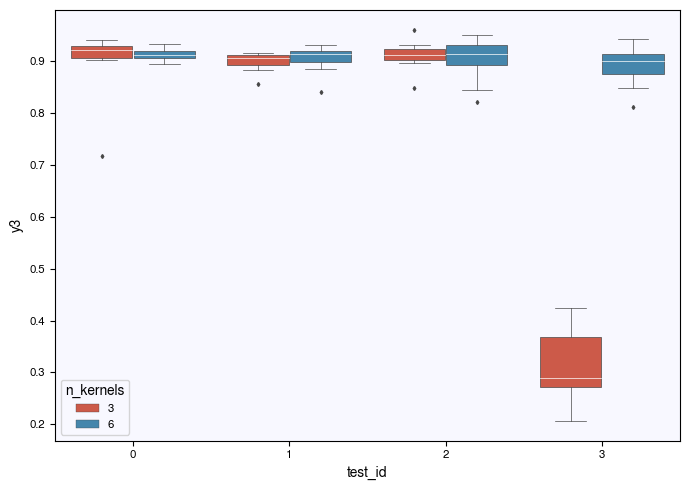

In [24]:
agreement_full = pd.concat([agreement_df, agreement6_df])
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=agreement_full[(agreement_full.kcid==0) & (agreement_full.weight=="quadratic")], x="test_id", y="y3", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Test id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

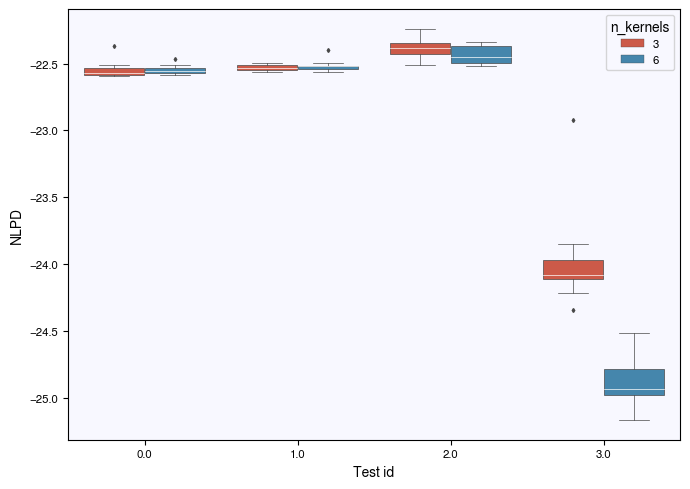

In [25]:
nlpd_all = pd.concat([nlpd_df, nlpd6_df])
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=nlpd_all[nlpd_all.kcid==0], x="test_id", y="total_nlpd", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
ax.set_ylabel("NLPD")
ax.set_xlabel("Test id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

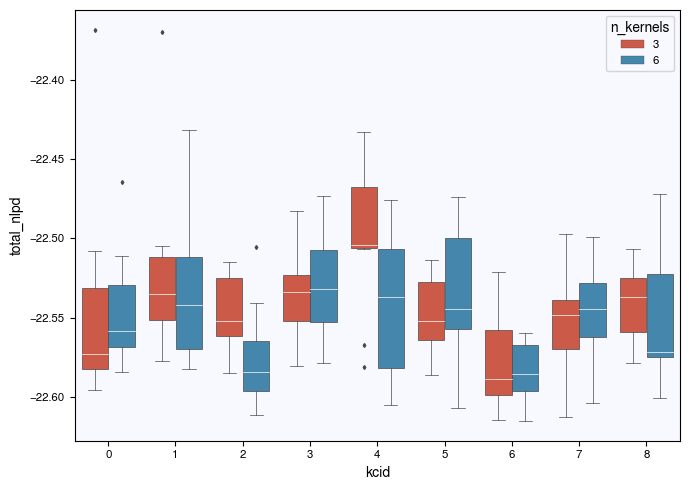

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=nlpd_all[nlpd_all.test_id==0], x="kcid", y="total_nlpd", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

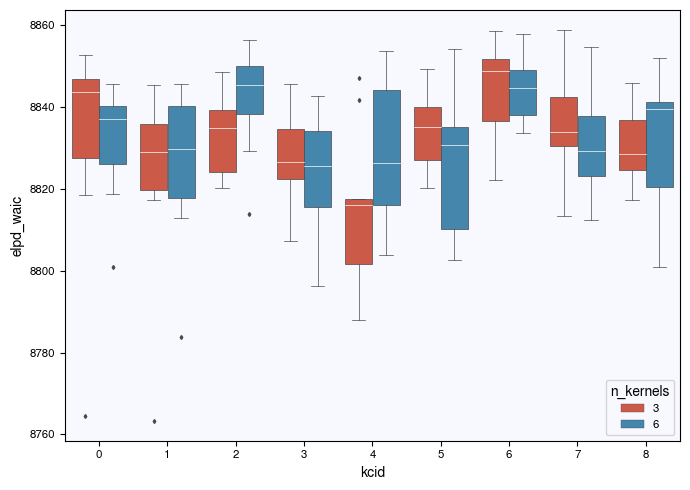

In [27]:
waic_all = pd.concat([waic_df, waic6_df])
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=waic_all[waic_all.test_id==0], x="kcid", y="elpd_waic", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

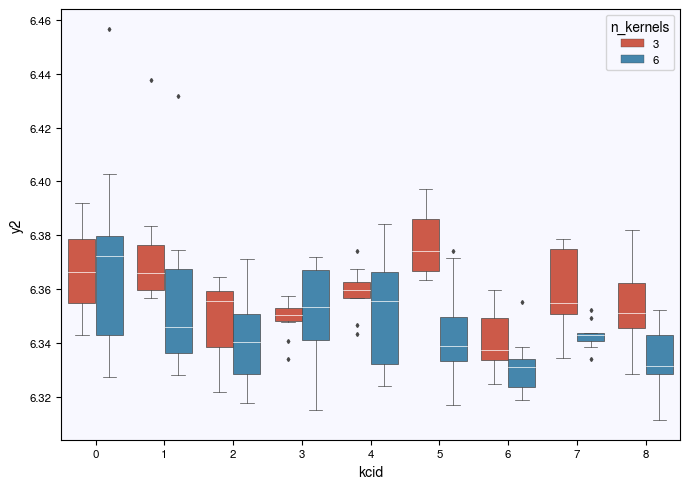

In [28]:
msce_all = pd.concat([msce_df, msce6_df])
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=msce_all[msce_all.test_id==0], x="kcid", y="y2", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

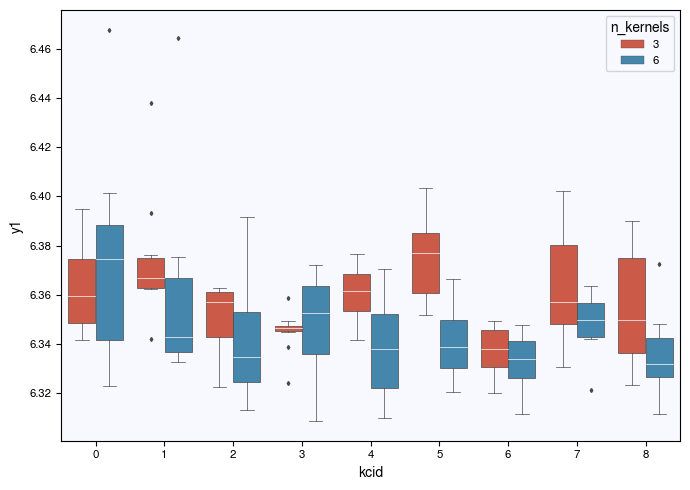

In [29]:
msce_all = pd.concat([msce_df, msce6_df])
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=msce_all[msce_all.test_id==0], x="kcid", y="y1", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Kernel combination id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

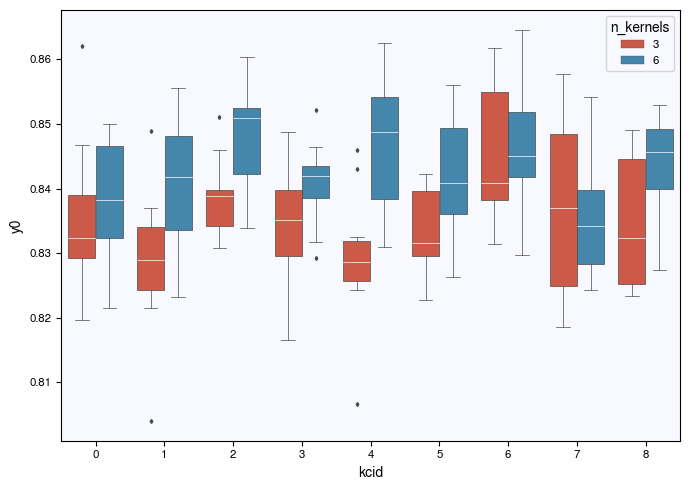

In [30]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=agreement_full[(agreement_full.test_id==0) & (agreement_full.weight=="quadratic")], x="kcid", y="y0", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Test id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

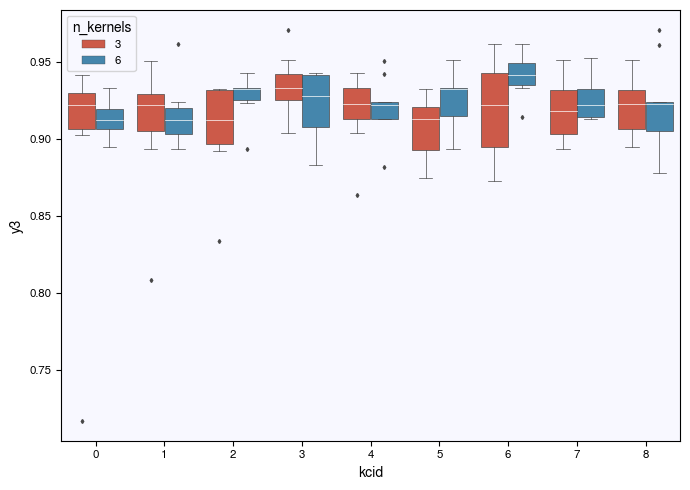

In [31]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=agreement_full[(agreement_full.test_id==0) & (agreement_full.weight=="quadratic")], x="kcid", y="y3", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Test id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

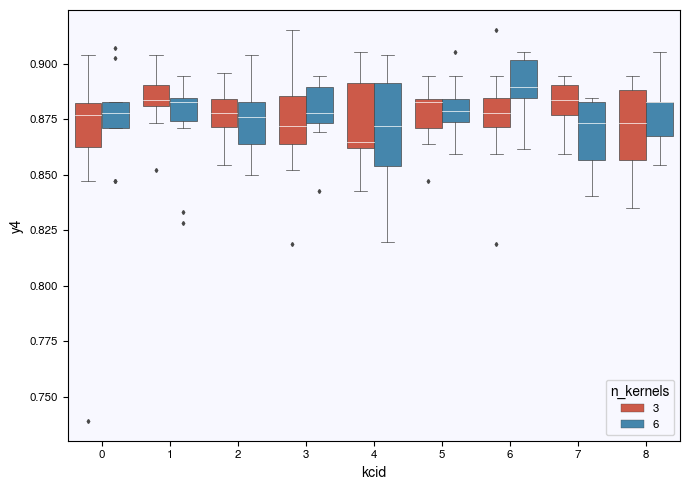

In [32]:
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=agreement_full[(agreement_full.test_id==0) & (agreement_full.weight=="quadratic")], x="kcid", y="y4", hue="n_kernels", linewidth=.5, fliersize=2, ax=ax, medianprops={"color": "white"})
# ax.set_ylabel("NLPD")
# ax.set_xlabel("Test id")
# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, model_legend, bbox_to_anchor=(1, 1))#, fontsize=10)
fig.tight_layout()

In [33]:
waic6_df.groupby(["test_id"]).median().reset_index()[["test_id", "p_waic"]]

,test_id,p_waic
0,0,14.280415
1,1,13.597598
2,2,132.462824
3,3,1327.777717


In [12]:
lmc0 = lmc6_df[lmc6_df.test_id==0].lmc_coeff.iloc[0]
lmc0 =  [float(i) for i in lmc0.strip('[|]').split()]
lmc1 = lmc6_df[lmc6_df.test_id==1].lmc_coeff.iloc[0]
lmc1 =  [float(i) for i in lmc1.strip('[|]').split()]

lmc_concat = np.concatenate([np.abs(lmc1), np.abs(lmc0)])
bins = np.linspace(0, lmc_concat.max()+.1, len(lmc0))
count0, _ = np.histogram(np.abs(lmc0), 
                           bins=bins)
count1, _ = np.histogram(np.abs(lmc1), 
                           bins=bins)

fig, ax = plt.subplots()

ax.step(x=np.arange(len(count0)), y=(count0.cumsum() - count1.cumsum()), where="post", c=color_cycle[1])
ax.set_xlim(0)
_, xmax = ax.get_xlim()
ax.hlines(0, 0, xmax, ls="--", colors="black", lw=1)

NameError: name 'lmc6_df' is not defined

(0.0, 5.0)

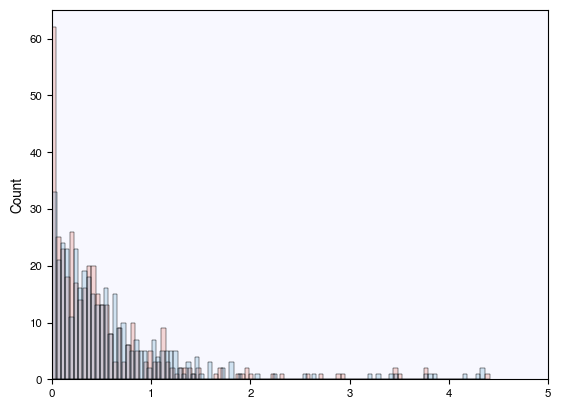

In [35]:
# fig, ax = plt.subplots(sharex=True)
sns.histplot(np.abs(lmc0), alpha=.2, bins=100)
sns.histplot(np.abs(lmc1), alpha=.2, bins=100)
plt.xlim(0,5)
# plt.ylim(0,15)

(0.0, 5.297414680438832)

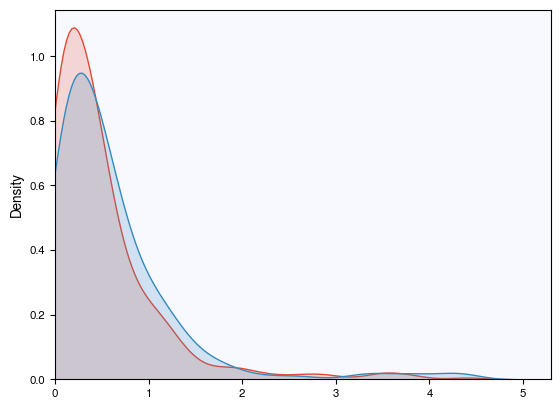

In [36]:
# fig, ax = plt.subplots(sharex=True)
sns.kdeplot(np.abs(lmc0), alpha=.2, fill=True)
sns.kdeplot(np.abs(lmc1), alpha=.2, fill=True)
plt.xlim(0)